In [4]:
vlib = c("tidyverse", "ggpubr", "patchwork", "tidyseurat", "future.apply",
   "arrow", "pheatmap", "ggrastr",  "Seurat", "hdWGCNA", "ggsci")
lapply(vlib, require, character.only = TRUE, quietly = TRUE) |> suppressMessages()

base_dir = "."

setwd(base_dir)

saveRDS.gz <- function(object, file, threads=4) {
  con <- pipe(paste0("pigz -p", threads, " > ", file), "wb")
  saveRDS(object, file = con)
  close(con)
}
readRDS.gz <- function(file, threads = parallel::detectCores()) {
  con <- pipe(paste0("pigz -d -c -p", threads, " ", file))
  object <- readRDS(file = con)
  close(con)
  return(object)
}

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] FALSE

[[8]]
[1] FALSE

[[9]]
[1] TRUE

[[10]]
[1] FALSE

[[11]]
[1] TRUE

In [ ]:
df_si = read_delim("tme_analysis/241027_sampleInfo.txt")
df_immunecell = read_delim("tme_analysis/putative_immune_cells.txt.gz")
int_filter_MinnFRNA = 200
int_filter_MaxnFRNA = 6000
int_filter_MaxpMT = 20


create_object = function(dir_10x, chr_project_name, df_si) {    
    seuratobj = Read10X(dir_10x) %>% CreateSeuratObject(counts = ., project = chr_project_name, min.cells = 3, min.features = 200)
    temp_meta = seuratobj@meta.data %>% 
        mutate(ID = as.character(orig.ident)) %>%
        rownames_to_column(var="barcode") %>%
        left_join(., df_si, by = ("ID")) %>%
        column_to_rownames("barcode")
    seuratobj@meta.data = temp_meta
    seuratobj[["percent.mt"]] <- PercentageFeatureSet(seuratobj, pattern = "^MT-")
    return(seuratobj)
} 
for(i in seq_along(df_si$ID)) {
    each_seurat_obj = create_object(paste0("tme_analysis/", df_si$ID[i], "/filtered_feature_bc_matrix"), df_si$ID[i], df_si)
    list_seurat_obj[[i]] = each_seurat_obj
}
for(i in seq_along(df_si$ID)) {
    list_seurat_obj[[i]] =  list_seurat_obj[[i]] %>%
      filter(nFeature_RNA > int_filter_MinnFRNA & 
             nFeature_RNA < int_filter_MaxnFRNA & 
             percent.mt < int_filter_MaxpMT)
}
seurat_obj = merge(x = list_seurat_obj[[1]], y = list_seurat_obj[2:length(list_seurat_obj)], merge.data=TRUE)
seurat_obj = JoinLayers(seurat_obj)
seurat_obj = subset(seurat_obj, cells = df_immunecell$CellID)
seurat_obj = SCTransform(seurat_obj)
seurat_obj[["SCT"]] <- split(seurat_obj[["SCT"]], f = seurat_obj$ID)
DefaultAssay(seurat_obj) = "SCT"
seurat_obj = NormalizeData(seurat_obj)
seurat_obj = FindVariableFeatures(seurat_obj)
seurat_obj = ScaleData(seurat_obj)
seurat_obj = RunPCA(seurat_obj)
seurat_obj = IntegrateLayers(
  object = seurat_obj, method = HarmonyIntegration,
  orig.reduction = "pca", new.reduction = "harmony",
  verbose = TRUE
)
seurat_obj = FindNeighbors(seurat_obj, reduction = "harmony", dims = 1:30)
c_resolution = c(0.3, 0.5, 0.7, 1.0)
seurat_obj = FindClusters(seurat_obj, resolution = c_resolution, cluster.name = paste0("harmony_clusters", c_resolution))
seurat_obj = RunUMAP(seurat_obj, reduction = "harmony", dims = 1:30, reduction.name = "umap.harmony")
seurat_obj = JoinLayers(seurat_obj)
DefaultAssay(seurat_obj) = "RNA"
seurat_obj = seurat_obj %>%
    NormalizeData() %>%
    ScaleData()

df_azimuth = read_delim("tme_analysis/azimuth_clusters.txt.gz") %>%
  select(CellID, orig.ident, predicted.ann_level_1:predicted.ann_finest_level, mapping.score)
new_md = seurat_obj@meta.data %>%
  rownames_to_column("CellID") %>%
  left_join(df_azimuth) %>%
  column_to_rownames("CellID")
seurat_obj@meta.data = new_md

# CD4 : 0,4,16,6,17,9,18,3
seurat_obj.cd4 = seurat_obj %>% filter(harmony_clusters1 %in% c(0, 4, 16, 6, 17, 9, 3))
# CD8 : 18, 10, 1, 2, 13, 15, 11, 7, 8 
seurat_obj.cd8 = seurat_obj %>% filter(harmony_clusters1 %in% c(18, 10, 1, 2, 13, 15, 11, 7, 8))
# Others : (5, 14: NK), (12: Proliferating T), (19: lymphatic EC)
seurat_obj.others = seurat_obj %>% filter(harmony_clusters1 %in% c(5,14,12,19))
ref.CD4 <- readRDS.gz("tme_analysis/sketched_CD4T_human_ref_v2.rds") %>% FindVariableFeatures()
ref.CD8 <- readRDS.gz("tme_analysis/sketched_CD8T_human_ref_v1.rds") %>% FindVariableFeatures()
anchors.CD4 <- FindTransferAnchors(reference = ref.CD4, query = seurat_obj.cd4, dims = 1:15,
    reference.reduction = "pca", normalization.method = "LogNormalize")
anchors.CD8 <- FindTransferAnchors(reference = ref.CD8, query = seurat_obj.cd8, dims = 1:15,
    reference.reduction = "pca", normalization.method = "LogNormalize")
df_id_only.CD8 = predictions.CD8 %>% select(predicted.id)
df_id_only.CD4 = predictions.CD4 %>% select(predicted.id)
df_id_only = rbind(df_id_only.CD4, df_id_only.CD8) %>% dplyr::rename(anno_l2 = predicted.id)

anno_l1 = data.frame(
    harmony_clusters1 = as.character(c(0, 4, 16, 6, 17, 9, 3, 18, 10, 1, 2, 13, 15, 11, 7, 8, 5, 14, 19, 12)),
    anno_l1 = c(rep("CD4", 7), rep("CD8", 9), rep("NK", 2), "Other", "Other")
)

anno_l2 = data.frame(
    harmony_clusters1 = as.character(c(5, 14, 19, 12)),
    anno_l2 = c("NK_1", "NK_2", "Lymphatic EC", "Proliferating_T")
)

df_anno_l1 = seurat_obj@meta.data %>%
  rownames_to_column("cellID") %>%
  select(cellID, harmony_clusters1) %>%
  left_join(anno_l1) %>% 
  dplyr::select(-harmony_clusters1)

df_id_only_others = seurat_obj@meta.data %>%
  rownames_to_column("cellID") %>%
  dplyr::filter(harmony_clusters1 %in% c(5,14,19,12)) %>%
  dplyr::select(harmony_clusters1, cellID) %>%
  left_join(anno_l2) %>%
  dplyr::select(-harmony_clusters1) %>%
  column_to_rownames("cellID")


df_id_only = rbind(df_id_only_others, df_id_only) %>%
  rownames_to_column("cellID") %>%
  left_join(df_anno_l1) %>%
  column_to_rownames("cellID")

df_id_only %>% rownames_to_column("cellID") %>% write_delim("cluster_anno_supervised.txt.gz")

seurat_obj <- AddMetaData(seurat_obj, metadata = df_id_only)

## figure 6A

In [ ]:
options(repr.plot.width = 7, repr.plot.height = 5, repr.plot.res = 200)
pDimPlot_l2 = DimPlot(seurat_obj, group.by = "anno_l2", 
   cols = pal_igv(alpha = 0.3)(30), label = TRUE, raster = TRUE,
   repel = TRUE, pt.size = 7, raster.dpi = c(2048, 2048)) & 
  theme(legend.position = "right")

pDimPlot_l2$data$anno_l2 = factor(pDimPlot_l2$data$anno_l2, 
  levels = c(
    paste0("CD4.", c("CTL_EOMES", "CTL_Exh", "CTL_GNLY", "NaiveLike", "Memory", "Tfh", "Th17", "Treg")),
    paste0("CD8.", c("NaiveLike", "CM", "EM", "TEMRA", "TPEX", "TEX", "MAIT")),
    "NK_1", "NK_2", "Proliferating_T", "Lymphatic EC"
  )
)

pDimPlot_l2 
ggsave("tme_analysis/figure_prep/pDimPlot.pdf", width = 7, height = 5)

### figure 6B

In [6]:
c_genes = c("GZMB", "PLEK", "CTSC", "APOBEC3G", 
"GSDMB", "IL18R1", "CTSW",
"TBX21", "EOMES", "IL2RB"
)


In [5]:
seurat_obj.tme.cd8 = readRDS.gz("/data/nfs_dell/project_HS/202310-sceqtl_v6/tme_analysis/seurat_obj_sct_harmony_immuneOnly_anno_241028.wgcna_projection.RDS")

In [11]:
 seurat_obj.tme.cd8 = seurat_obj.tme.cd8 %>% filter(anno_l1 == "CD8_T")

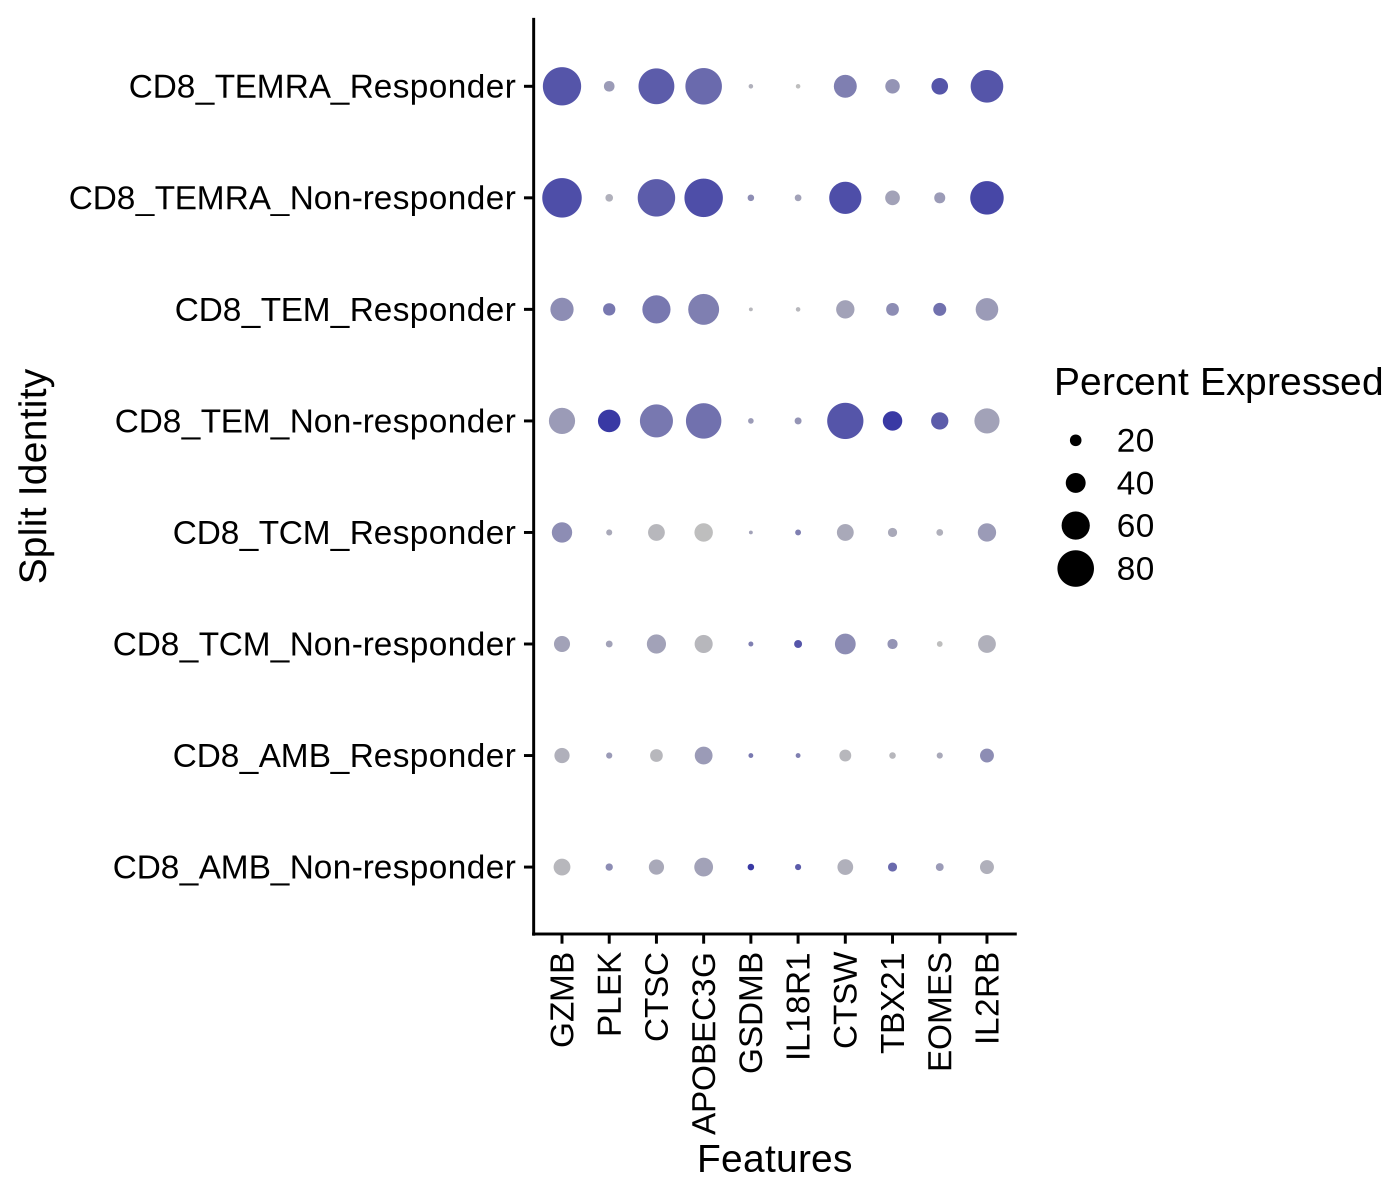

In [12]:
pDEG_dotPlot = seurat_obj.tme.cd8 %>%
  DotPlot(
    features = c_genes, 
    group.by = "anno_l2",
    split.by = "Binary_response",
    cols = c("#3939a4", "#3939a4", "lightgrey")
    )
options(repr.plot.width = 7, repr.plot.height = 6, repr.plot.res = 200)
pDEG_dotPlot & theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))
#ggsave("tme_analysis/figure_prep/pDot_selected_genes.pdf", width = 7, height = 6)

### figure 6C

In [13]:
theme_2 = theme(axis.text.x = element_blank(), axis.title.x = element_blank(), axis.title.y = element_blank())
theme_3 = theme(axis.title.x = element_blank(), axis.title.y = element_blank())

In [17]:
p1 = VlnPlot(seurat_obj.tme.cd8,
  assay = "RNA",
  features = c_genes,
  group.by = "Binary_response",
  pt.size = 0,
  ncol = 5,
  combine = FALSE
)

library(presto)
df_deg = wilcoxauc(seurat_obj.tme.cd8, seurat_assay = "RNA", group_by = "Binary_response" )
p.values = df_deg %>%
  filter(feature %in% c_genes) %>%
  mutate(feature = factor(feature, levels = c(c_genes))) %>%
  filter(group == "Non-responder") %>% 
  arrange(feature) %>% pull(padj) %>% format(., digits = 3)

for (i in 1:10) {
    p1[[i]]$data$ident = factor(as.character(p1[[i]]$data$ident), levels= c("Responder", "Non-responder"))
    p1[[i]]$layers[[1]]$aes_params$size = 0
}

Loading required package: Rcpp

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the presto package.
  Please report the issue to the authors.”


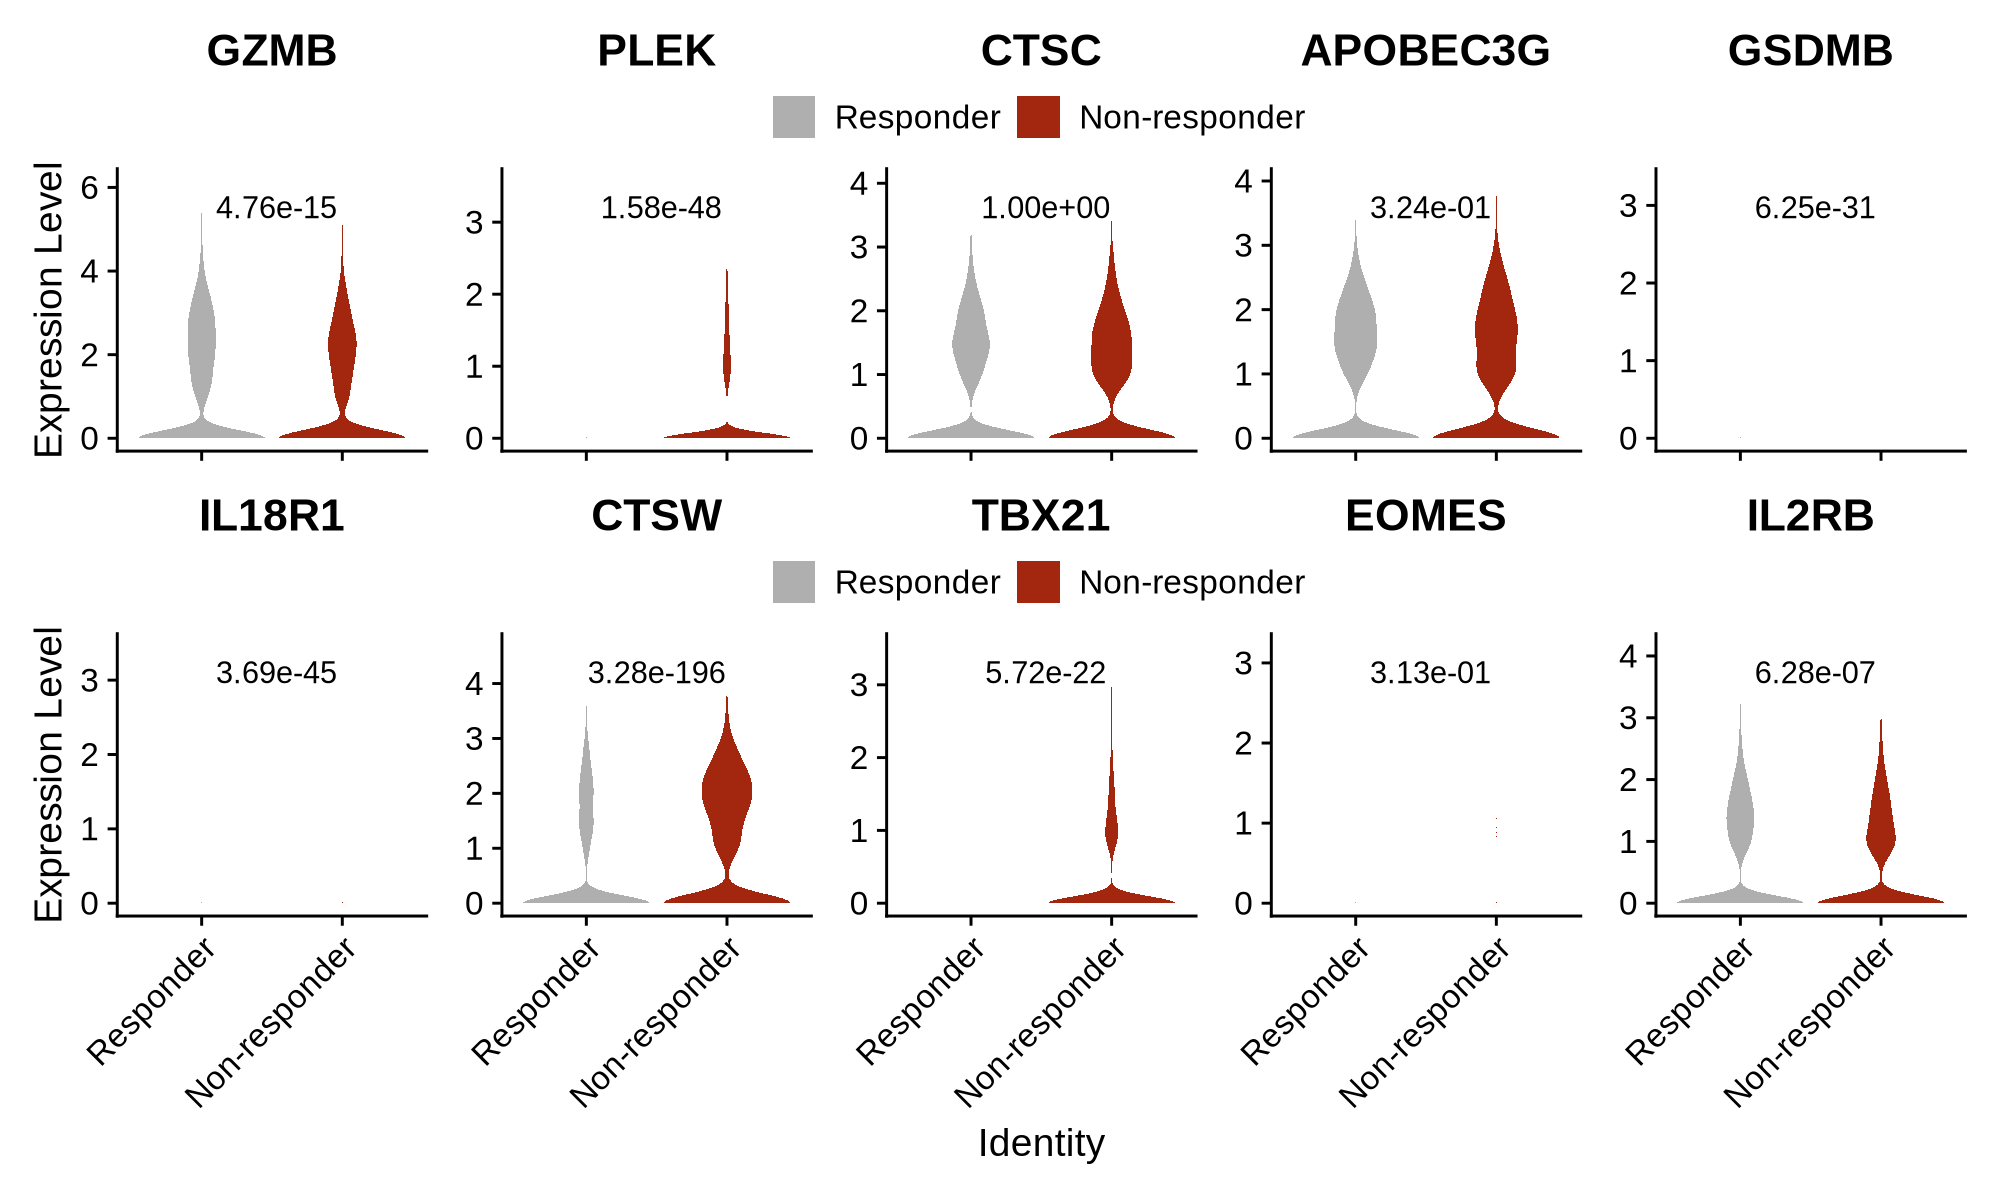

In [18]:
library(patchwork)
phigh = (
    (p1[[1]] + 
       theme(axis.text.x = element_blank(), axis.title.x = element_blank(), legend.position = "none") +
       scale_fill_manual(values = c("#afafaf", "#a3260f")) +
       scale_color_manual(values = c("#FFFFFFFF", "#FFFFFFFF")) +
       annotate("text", x = 1.5, y = max(p1[[1]]$data[,1])*0.9, label = p.values[1])
    ) +
    (p1[[2]] +
       theme_2+
       scale_fill_manual(values = c("#afafaf", "#a3260f")) +
       scale_color_manual(values = c("#FFFFFFFF", "#FFFFFFFF")) +
       annotate("text", x = 1.5, y = max(p1[[2]]$data[,1])*0.9, label = p.values[2])
    )+
    (p1[[3]] +
       theme_2+
       scale_fill_manual(values = c("#afafaf", "#a3260f")) +
       scale_color_manual(values = c("#FFFFFFFF", "#FFFFFFFF")) +
       annotate("text", x = 1.5, y = max(p1[[3]]$data[,1])*0.9, label = p.values[3])
    )+
    (p1[[4]] +
       theme_2+
       scale_fill_manual(values = c("#afafaf", "#a3260f")) +
       scale_color_manual(values = c("#FFFFFFFF", "#FFFFFFFF")) +
       annotate("text", x = 1.5, y = max(p1[[4]]$data[,1])*0.9, label = p.values[4])
    )+
    (p1[[5]]+
       theme_2+
       scale_fill_manual(values = c("#afafaf", "#a3260f")) +
       scale_color_manual(values = c("#FFFFFFFF", "#FFFFFFFF")) +
       annotate("text", x = 1.5, y = max(p1[[5]]$data[,1])*0.9, label = p.values[5])
    )
)
plow = (
    (p1[[6]] + 
      theme(axis.title.x = element_blank())+
       scale_fill_manual(values = c("#afafaf", "#a3260f")) +
       scale_color_manual(values = c("#FFFFFFFF", "#FFFFFFFF")) +
       annotate("text", x = 1.5, y = max(p1[[6]]$data[,1])*0.9, label = p.values[6])
    ) +
    (p1[[7]] + 
      theme_3+
      scale_fill_manual(values = c("#afafaf", "#a3260f")) +
      scale_color_manual(values = c("#FFFFFFFF", "#FFFFFFFF")) +
      annotate("text", x = 1.5, y = max(p1[[7]]$data[,1])*0.9, label = p.values[7])
    ) +
    (p1[[8]] +
      theme(axis.title.y = element_blank())+
      scale_fill_manual(values = c("#afafaf", "#a3260f")) +
      scale_color_manual(values = c("#FFFFFFFF", "#FFFFFFFF")) +
      annotate("text", x = 1.5, y = max(p1[[8]]$data[,1])*0.9, label = p.values[8])
    )+
    (p1[[9]] +
      theme_3+
      scale_fill_manual(values = c("#afafaf", "#a3260f")) +
      scale_color_manual(values = c("#FFFFFFFF", "#FFFFFFFF")) +
      annotate("text", x = 1.5, y = max(p1[[9]]$data[,1])*0.9, label = p.values[9])
    )+
    (p1[[10]] +
      theme_3+
      scale_fill_manual(values = c("#afafaf", "#a3260f")) +
      scale_color_manual(values = c("#FFFFFFFF", "#FFFFFFFF")) +
      annotate("text", x = 1.5, y = max(p1[[10]]$data[,1])*0.9, label = p.values[10])
    )
)
options(repr.plot.width = 10, repr.plot.height = 6, res = 100)
(phigh + plot_layout(ncol = 5,guides = "collect"))/ (plow + plot_layout(ncol = 5,guides = "collect"))  & theme(legend.position = "top") 

#ggsave("tme_analysis/figure_prep/pVln_selected_genes.pdf", width = 10, height = 6)

In [21]:
library(hdWGCNA)

Loading required package: harmony

Loading required package: ggrepel

Loading required package: WGCNA

Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor


Loading required package: igraph


Attaching package: ‘igraph’


The following object is masked from ‘package:Seurat’:

    components


The following objects are masked from ‘package:future’:

    %->%, %<-%


The following objects are masked from ‘package:lubridate’:

    %--%, union


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is masked from ‘package:tibble’:

    as_data_frame


The following

Joining with `by = join_by(cellID)`


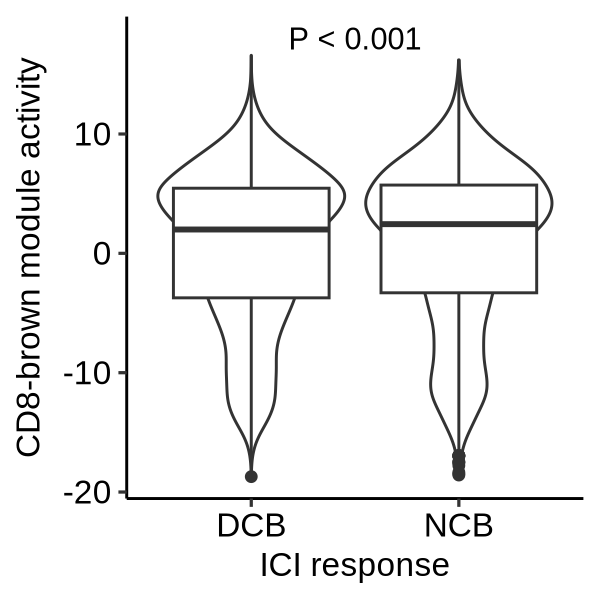

In [44]:
df_ME = GetMEs(seurat_obj.tme.cd8) %>% as.data.frame() %>% rownames_to_column("cellID")
df_md = seurat_obj.tme.cd8@meta.data %>% as.data.frame() %>% rownames_to_column("cellID")

options(repr.plot.width = 3, repr.plot.height = 3, res = 200)
left_join(df_ME, df_md) %>%
    filter(is.na(Binary_response) == FALSE) %>%
    mutate(Binary_response = ifelse(Binary_response == "Non-responder", "NCB", "DCB")) %>%
    ggplot(aes(x = Binary_response, y= brown)) + geom_violin() + geom_boxplot() + theme_pubr() +
    scale_fill_manual(values = c("#afafaf", "#a3260f")) +
    scale_color_manual(values = c("#FFFFFFFF", "#FFFFFFFF"))+
    ylab("CD8-brown module activity")+
    xlab("ICI response")+
    annotate("text", x = 1.5, y = 18, label = "P < 0.001")

ggsave("SF8D.pdf", width = 3, height = 3)